# Perform online segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../dev/
from dataset_creation_aprovis3d import aprovis3dDataset

/home/antoine/homhots/aprovhots/dev


In [3]:
import tonic, torch, os, pickle, copy, sys
from tqdm import tqdm
from hots.network import network
from hots.layer import mlrlayer
from hots.timesurface import timesurface
from hots.utils import apply_jitter, get_loader, get_dataset_info, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [4]:
path = '../../Data/RGB_frames2events/'
# gives the data type - here we use experimental data, stored as npy
data_type = 'synthetic'
# gives a patch_size to divide spatially the event streams
patch_size = (672, 376)
# gives a max duration for the samples of the dataset to divide temporally the event streams
max_duration = 1e3 # (in ms)
# labels given to the different classes of the dataset
labelz = ['sea','gro']
# original sensor_size of the DVS (width,height,polarity)
sensor_size = [672, 376, 2]
# discard samples with less than min_num_events events
min_num_events = 1000
# split the recordings into train and test sets with train_test_ratio ratio
train_test_ratio = .75
# gives the indexing of the event stream
ordering = 'xytp'

trainset = aprovis3dDataset(save_to=path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
testset = aprovis3dDataset(save_to=path, data_type=data_type, classes=labelz, train=False, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
trainloader = get_loader(trainset)
testloader = get_loader(testset)

num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(trainset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 69
number of samples in the testing set: 24


In [5]:
events, target = next(iter(trainloader))

In [6]:
print(events.shape)

torch.Size([1, 100910, 4])


In [7]:
events[0,:,2] = events[0,:,2]-events[0,0,2]
print(events)

tensor([[[   583,    334,      0,     -1],
         [   146,     28,      0,     -1],
         [   380,    179,     15,      1],
         ...,
         [   225,     81, 999944,      1],
         [    30,    116, 999951,      1],
         [   283,    179, 999962,     -1]]])


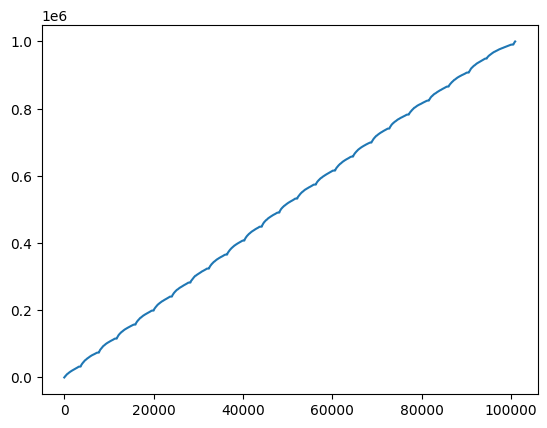

In [8]:
plt.plot(events[0,:,2])

In [9]:
TSs, ind_filtered = timesurface(events[0,:2000,:].squeeze(), trainset.sensor_size, trainset.ordering, tau = 5e4)

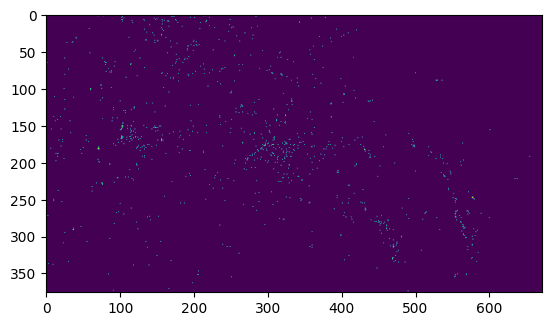

In [10]:
event_indice = 1000
ts_off = plt.imshow(TSs[event_indice][1,:,:])

## Run the core HOTS network

In [ ]:
name = 'homeohots'
homeo = True
timestr = '2023-01-03'
dataset_name = 'aprovis_UCA_no_patch'
ts_batch_size = int(5e4) 

Rz = [4, 8]
N_neuronz = [16, 32]
tauz = [6e4*2, 6e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

record_path = path+'Records/'

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
    os.mkdir(record_path+'output/')
    os.mkdir(record_path+'output/train/')
    os.mkdir(record_path+'output/test/')
    os.mkdir(record_path+'LR_results/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(trainloader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size)

  1%|██                                                                                                                                            | 1/69 [02:49<3:11:48, 169.24s/it]

In [ ]:
hots.plotlayers();

In [ ]:
hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=False, verbose=False)

## Example with only one layer of Multinomial Logistic Regression (MLR)

In [ ]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
betas = (0.9, 0.999)
num_epochs = 2 ** 5 + 1
N_polarities = 32
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_polarities)
tau_cla = 6e4*32
mlr_layer_name = f'{timestr}_LR_{tau_cla}_{ts_size}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

model_path = record_path+'networks/' + mlr_layer_name
results_path = record_path+'LR_results/' + mlr_layer_name
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
train_path = record_path+f'output/train/{hots.name}_{num_sample_test}_{jitter}/'

classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

In [ ]:
testloader = get_loader(trainset, kfold=2, kfold_ind=1)

mlr_threshold = None
ts_batch_size = None

#results_path = results_path[:-4]+'trainset.pkl'

onlinac = online_accuracy(classif_layer, tau_cla, testloader, results_path, ts_size, trainset.ordering, len(labelz), mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, original_accuracy = None, original_accuracy_nohomeo = None, online_plot=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(onlinac[0])

In [ ]:
print(results_path[:-4])